**Loading Framework**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import log_loss


**DATA PREPARATION & EDA**

In [2]:
df = pd.read_csv("/Users/bhavyagupta/Downloads/insurance.csv")

In [3]:

print(df.head())
print(df.info())
print(df.describe())
print("Missing Values:\n", df.isnull().sum())


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000 

**OUTLIER REMOVAL (IQR METHOD)**

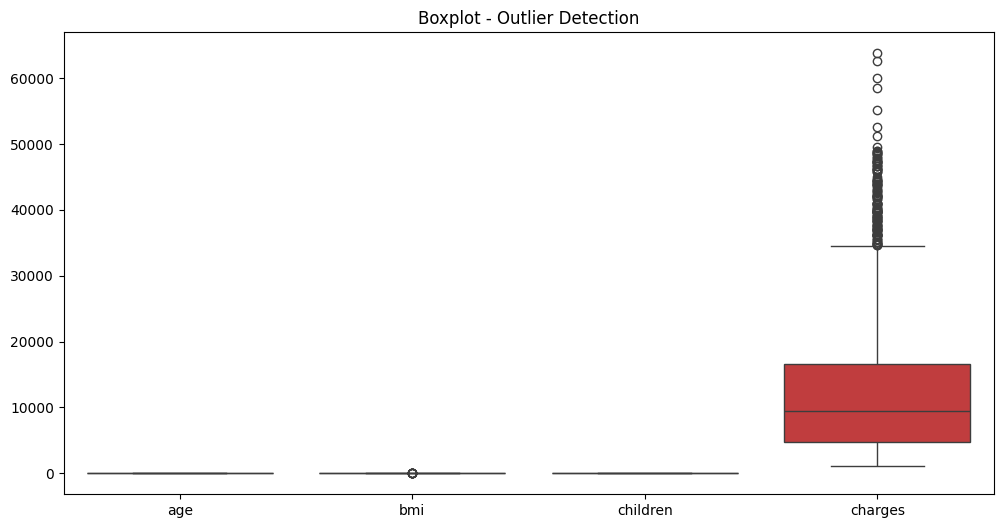

In [4]:

plt.figure(figsize=(12,6))
sns.boxplot(data=df.select_dtypes(include=np.number))
plt.title("Boxplot - Outlier Detection")
plt.show()

num_cols = ['age', 'bmi', 'children', 'charges']
Q1 = df[num_cols].quantile(0.40)
Q3 = df[num_cols].quantile(0.60)
IQR = Q3 - Q1

df = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) |
          (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


(512, 7)


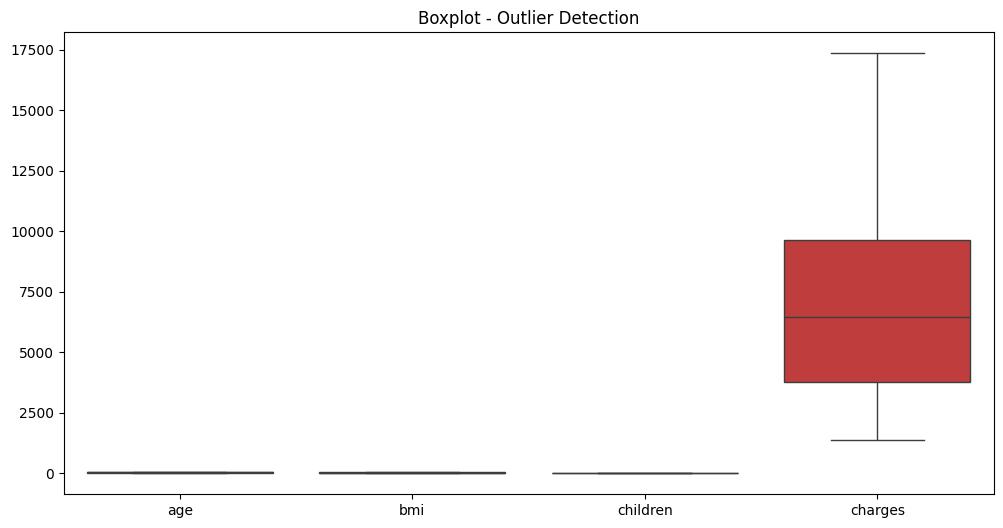

In [5]:
print(df.shape)
plt.figure(figsize=(12,6))
sns.boxplot(data=df.select_dtypes(include=np.number))
plt.title("Boxplot - Outlier Detection")
plt.show()


**ENCODING**

In [6]:

le = LabelEncoder()
for col in ['sex', 'smoker', 'region']:
    df[col] = le.fit_transform(df[col])


**FEATURE SCALING**

In [7]:
scaler = StandardScaler()
df[['age','bmi','children']] = scaler.fit_transform(
    df[['age','bmi','children']]
)


**CORRELATION ANALYSIS**

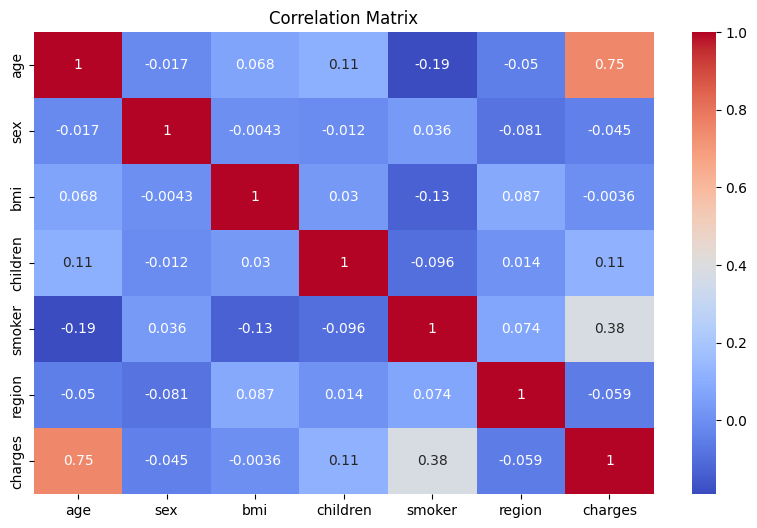

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


**REGRESSION**

In [9]:
X = df.drop('charges', axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


**Simple Linear Regression**

In [10]:
slr = LinearRegression()
slr.fit(X_train[['age']], y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
y_pred_slr = slr.predict(X_test[['age']])


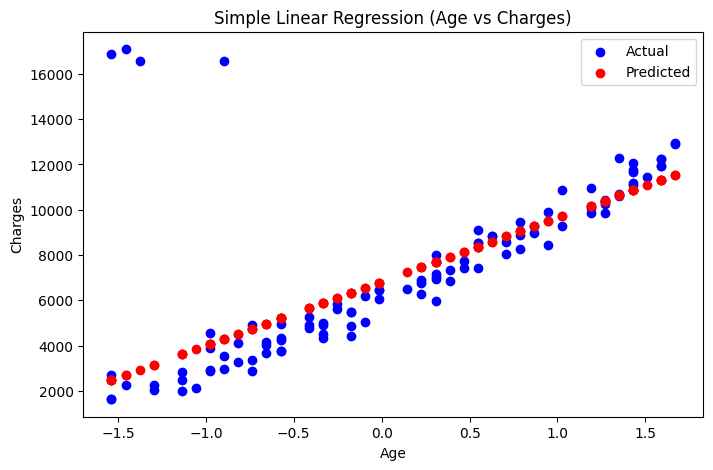

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(X_test['age'], y_test, color='blue', label='Actual')
plt.scatter(X_test['age'], y_pred_slr, color='red', label='Predicted')
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Simple Linear Regression (Age vs Charges)")
plt.legend()
plt.show()


**Multiple Linear Regression**

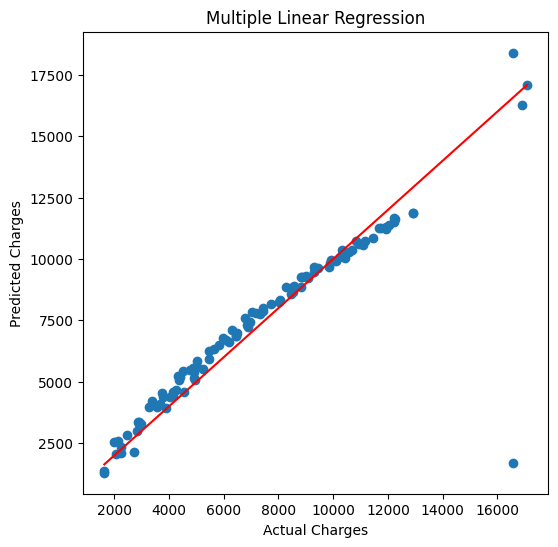

In [13]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_mlr = mlr.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_mlr)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Multiple Linear Regression")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')
plt.show()

**Polynomial Regression**

In [14]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X[['age']])

Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

poly_lr = LinearRegression()
poly_lr.fit(Xp_train, yp_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


**Create age range WITH feature name**

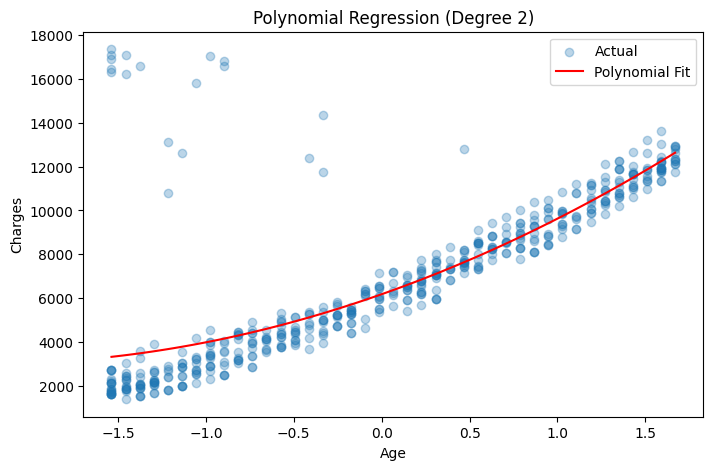

In [15]:
age_range = pd.DataFrame(
    np.linspace(X['age'].min(), X['age'].max(), 100),
    columns=['age']
)

age_range_poly = poly.transform(age_range)
charges_poly_pred = poly_lr.predict(age_range_poly)

plt.figure(figsize=(8,5))
plt.scatter(X['age'], y, alpha=0.3, label='Actual')
plt.plot(age_range['age'], charges_poly_pred, color='red', label='Polynomial Fit')
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Polynomial Regression (Degree 2)")
plt.legend()
plt.show()


**Regression Metrics**

In [16]:
print("MAE:", mean_absolute_error(y_test, y_pred_mlr))
print("MSE:", mean_squared_error(y_test, y_pred_mlr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlr)))
print("R2:", r2_score(y_test, y_pred_mlr))



MAE: 602.8779066419154
MSE: 2446613.635724985
RMSE: 1564.1654758128966
R2: 0.8160823830615336


**CLASSIFICATION**

In [17]:
df['High_Cost'] = (df['charges'] > df['charges'].median()).astype(int)

X = df.drop(['charges','High_Cost'], axis=1)
y = df['High_Cost']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**KNN Evaluation**

KNN Accuracy: 0.883495145631068


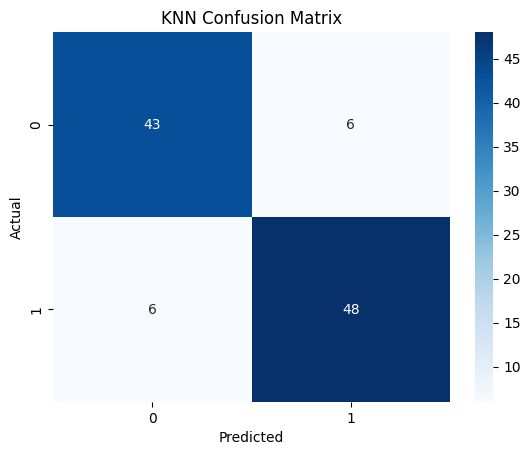

In [18]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

sns.heatmap(
    confusion_matrix(y_test, y_pred_knn),
    annot=True, fmt='d', cmap='Blues'
)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Naive Bayes Evaluation**

Naive Bayes Accuracy: 0.5631067961165048
Precision: 1.0
Recall: 0.16666666666666666
F1 Score: 0.2857142857142857


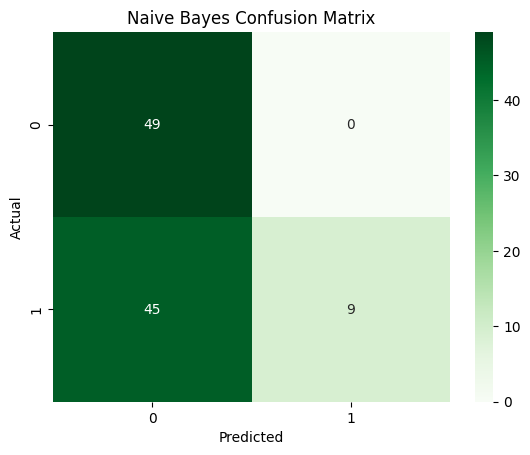

In [19]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb))

sns.heatmap(
    confusion_matrix(y_test, y_pred_nb),
    annot=True, fmt='d', cmap='Greens'
)
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Decision Tree**

In [20]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)


**Plot Decision Tree**

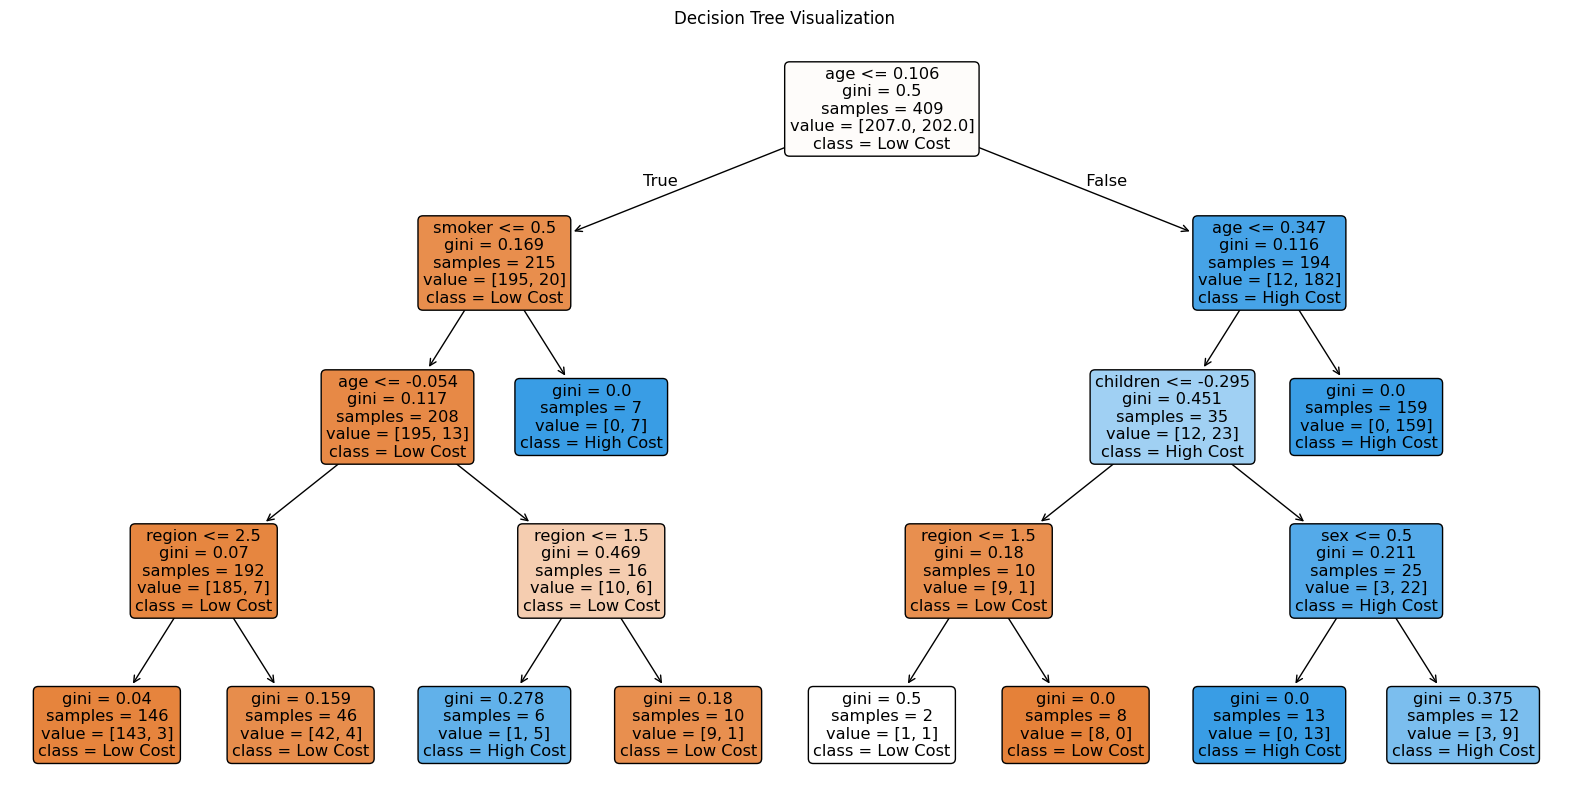

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=X_train.columns,
    class_names=['Low Cost', 'High Cost'],
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()


**SVM**

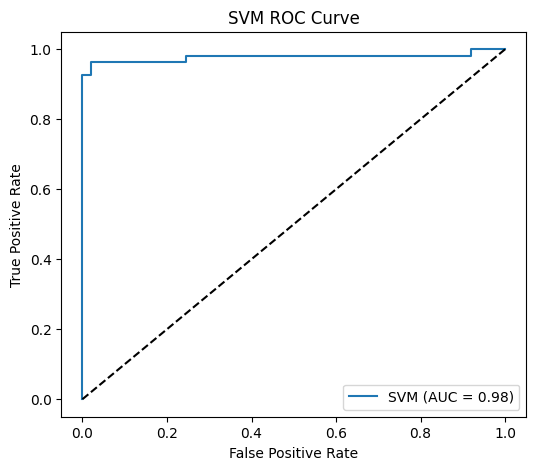

In [22]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)


fpr, tpr, _ = roc_curve(y_test, y_prob_svm[:,1])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='SVM (AUC = %.2f)' % roc_auc_score(y_test, y_prob_svm[:,1]))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend()
plt.show()


**Classification Metrics**

In [23]:
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("Log Loss:", log_loss(y_test, y_prob_svm))
print("AUC:", roc_auc_score(y_test, y_prob_svm[:,1]))


Accuracy: 0.941747572815534
Precision: 0.9285714285714286
Recall: 0.9629629629629629
F1 Score: 0.9454545454545454
Log Loss: 0.18285103895571111
AUC: 0.9777021919879063


**Confusion Matrix**

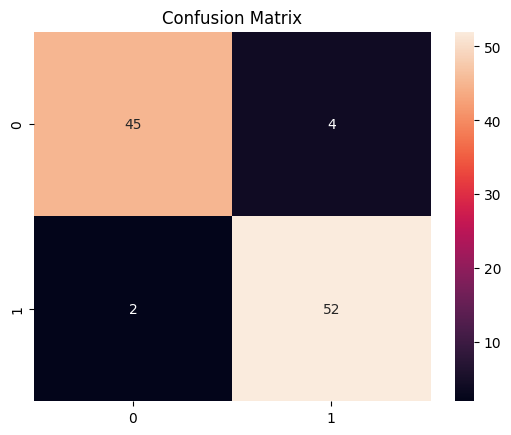

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


**K-Means(Unsupervised Learning)**

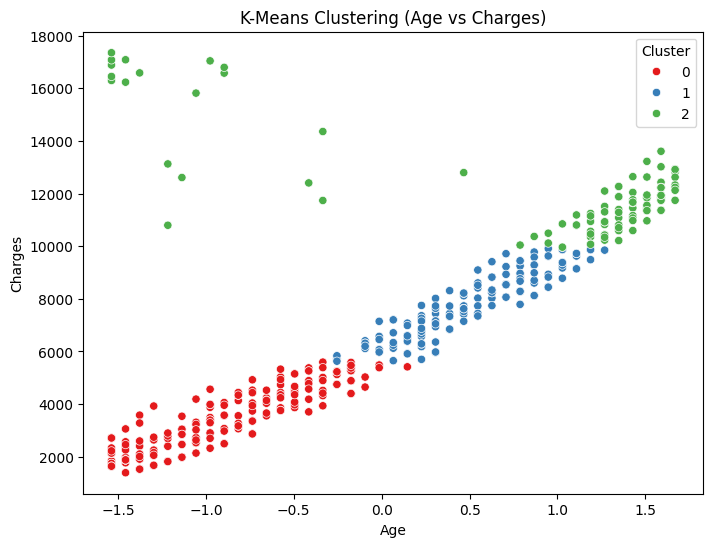

In [25]:
X_cluster = df[['age','bmi','charges']]

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df['age'],
    y=df['charges'],
    hue=df['Cluster'],
    palette='Set1'
)
plt.title("K-Means Clustering (Age vs Charges)")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()
